In [ ]:
import math
import numpy as np
import pandas as pd
from numpy import array
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras import initializers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import pyarrow.feather as feather
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

tfd = tfp.distributions

# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X,y = list(),list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix,:-1], sequences[end_ix,2] # x columns are inputs and y comlumns are targets
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# choose a number of time steps (lookback)
n_steps = 3 
n_features = 2 
rolling = 504

In [ ]:
# load GARCH data
garch_forecasts = feather.read_feather('../EXPORTS/garch_forecasts_dt_bvp.feather')
garch_forecasts

,Realized Ret,sGARCH_norm_mu,sGARCH_norm_sigma,sGARCH_norm_skew,sGARCH_norm_shape,sGARCH_std_mu,sGARCH_std_sigma,sGARCH_std_skew,sGARCH_std_shape,sGARCH_sstd_mu,...,apARCH_std_skew,apARCH_std_shape,apARCH_sstd_mu,apARCH_sstd_sigma,apARCH_sstd_skew,apARCH_sstd_shape,vYZ_252,vGKYZ,SvOLHC,vGKYZ_252
0,1.915317,-0.026271,1.976414,0.0,0.0,-0.037803,1.980495,0.0,16.277337,-0.039948,...,0.0,22.569931,-0.096900,2.120035,0.933060,17.502197,1.564780,0.820208,1.112577,1.302040
1,0.268969,0.038601,1.996078,0.0,0.0,0.014820,1.994624,0.0,16.456272,0.011019,...,0.0,22.889573,-0.057939,2.067497,0.929056,17.677872,1.153990,0.756105,1.025624,1.200279
2,-1.644311,-0.016927,1.916980,0.0,0.0,-0.028222,1.917184,0.0,18.123626,-0.026928,...,0.0,24.851029,-0.063380,2.018034,0.981810,22.047885,1.173934,0.745252,1.010902,1.183051
3,-1.151685,-0.120906,1.927087,0.0,0.0,-0.116823,1.920377,0.0,17.821740,-0.116150,...,0.0,21.660796,-0.153619,2.052307,0.987628,21.504994,2.108000,1.846017,2.504043,2.930462
4,1.739710,-0.099187,1.889527,0.0,0.0,-0.099692,1.881693,0.0,18.021125,-0.098874,...,0.0,21.938736,-0.134837,2.026781,0.984120,21.779448,2.556038,1.312344,1.780137,2.083281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,0.699998,0.278883,1.370508,0.0,0.0,0.369402,1.331419,0.0,7.017618,0.346584,...,0.0,6.799233,0.377800,1.172383,0.775694,7.497988,2.040711,0.627255,0.850845,0.995737
4688,0.998715,0.100321,1.283334,0.0,0.0,0.099509,1.260530,0.0,6.833599,0.044738,...,0.0,6.504629,0.052286,1.149280,0.794018,7.491827,1.054731,0.794669,1.077934,1.261498
4689,1.111561,0.079979,1.252211,0.0,0.0,0.070001,1.235211,0.0,6.891952,0.011649,...,0.0,6.310745,-0.013239,1.119527,0.799003,7.258728,0.901572,0.476932,0.646938,0.757106
4690,0.239380,0.074058,1.244937,0.0,0.0,0.061489,1.229597,0.0,6.967399,0.001967,...,0.0,5.888166,0.002626,1.084492,0.781870,7.326373,0.808480,0.642117,0.871003,1.019328


In [ ]:
# convert to [rows, columns] structure
in_seq1 = garch_forecasts[['Realized Ret']] 
in_seq2 = abs(garch_forecasts[['Realized Ret']])
in_seq3 = garch_forecasts[['sGARCH_norm_sigma']]
in_seq4 = garch_forecasts[['vGKYZ_252']]
# horizontally stack columns
dataset = np.hstack(( in_seq1, in_seq4, in_seq1)) 

In [ ]:
garch_forecasts[['eGARCH_sstd_sigma']].describe()

In [ ]:
def loss_norm(y_true,y_pred):
    
    mu=tf.slice(y_pred,[0,0],[-1,1])
    sigma= 1e-3 + tf.math.softplus(0.01* tf.slice(y_pred,[0,1],[-1,1]))
    
    a=1/(tf.sqrt(2.*math.pi)*sigma)
    b1=tf.square(mu-y_true)
    b2=2*tf.square(sigma)
    
    b=b1/b2

    loss = tf.reduce_mean(-tf.math.log(a)+b,axis=0)
    return loss

In [90]:
loss_norm(y,y_pred)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([41364.32], dtype=float32)>

In [91]:
def loss_norm2(y_true,y_pred):
    
    mu=tf.slice(y_pred,[0,0],[-1,1])
    sigma= 1e-3 + tf.math.softplus(0.01* tf.slice(y_pred,[0,1],[-1,1]))
    
    a=1/2*tf.math.log(2.*math.pi*tf.square(sigma))
    b1=tf.square(mu-y_true)
    b2=2*tf.square(sigma)
    
    b=b1/b2

    #tu można zmienić sum na mean żeby mieć średnią po batch size, tak jak jest w dist lambda
    loss = tf.reduce_mean(a+b,axis=0)
    return loss

In [ ]:
def loss_norm3(y_true,y_pred):
    
    mu=tf.slice(y_pred,[0,0],[-1,1])
    sigma= 1e-3 + tf.math.softplus(0.01* tf.slice(y_pred,[0,1],[-1,1]))
    
    a=1/2*tf.math.log(2.*math.pi)   +1/2*tf.math.log(tf.square(sigma))
    b1=tf.square(mu-y_true)
    b2=2*tf.square(sigma)
    
    b=b1/b2

    loss = tf.reduce_mean(a+b,axis=0)
    return loss

In [3]:
def softplusinv(x):
    return tf.math.log(tf.exp(x) - 1.) 

In [ ]:
#Loss for Student's t distribution
def loss_st(y_true,y_pred):
    mu= tf.slice(y_pred,[0,0],[-1,1])
   
    sigma= 1e-3 + tf.math.softplus(0.01* tf.slice(y_pred,[0,1],[-1,1]))
    nu= 1e-3 + tf.math.softplus(0.01 * tf.slice(y_pred,[0,2],[-1,1]))

   
    a1 = tf.exp(tf.math.lgamma((nu+1.)/2.)) 
    a2 = tf.exp(tf.math.lgamma((nu/2.))) 
    a = a1/a2
    b = (1./2.)*tf.math.log(nu*math.pi)
    c = (1./2.)*tf.math.log(tf.square(sigma))
    d = (nu +1)/2.
    e = 1. + (tf.square(y_true-mu))/(nu*tf.square(sigma))
    
    loss = tf.reduce_mean(-tf.math.log(a) + b + c + d * tf.math.log(e) ,axis=0)
    return loss

In [ ]:
#For skewed Student's t distribution
def loss_skew_st(y_true,y_pred):
    mu= tf.slice(y_pred,[0,0],[-1,1])
    sigma= 1e-3 + tf.math.softplus(0.01 * tf.slice(y_pred,[0,1],[-1,1]))
    nu= 1e-3 + tf.math.softplus(0.01 * tf.slice(y_pred,[0,2],[-1,1]))

    #from 0-1 left asym, from 1 to inf right asym
    xi= 1e-3 + tf.math.softplus(0.01 * tf.slice(y_pred,[0,3],[-1,1]))
    
    expr1 = -tf.math.log(2/(xi+(1/xi)))
    

    a1 = tf.exp(tf.math.lgamma((nu+1.)/2.)) 
    a2 = tf.exp(tf.math.lgamma((nu/2.))) 
    
    b = tf.math.sqrt(nu*math.pi)

    a = a1/(a2*b)

    c = tf.math.log(sigma) 
    d = (nu +1)/2.
    

    epst = (y_true - mu) / sigma 

    H_positive = tf.where(epst > 0, 
                    1.,
                    0.)


    stneg_kernel = tf.math.pow((1+ (tf.square(xi*epst)/nu)),-d)
    stpos_kernel = tf.math.pow((1+ (tf.square(epst)/(tf.square(xi)*nu))),-d)

    
    loss = tf.reduce_mean(expr1 +   c    -tf.math.log(a * (stneg_kernel*(1.-H_positive)+stpos_kernel*H_positive)) ,axis=0)
    return loss

training the model...
Epoch 1/300

Epoch 1: val_loss improved from inf to 2.29612, saving model to best_model.h5
21/21 - 2s - loss: 2.2211 - val_loss: 2.2961 - 2s/epoch - 102ms/step
Epoch 2/300

Epoch 2: val_loss did not improve from 2.29612
21/21 - 0s - loss: 2.1569 - val_loss: 2.2998 - 134ms/epoch - 6ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 2.29612
21/21 - 0s - loss: 2.1483 - val_loss: 2.3226 - 138ms/epoch - 7ms/step
Epoch 4/300

Epoch 4: val_loss improved from 2.29612 to 2.28982, saving model to best_model.h5
21/21 - 0s - loss: 2.1448 - val_loss: 2.2898 - 139ms/epoch - 7ms/step
Epoch 5/300

Epoch 5: val_loss improved from 2.28982 to 2.26966, saving model to best_model.h5
21/21 - 0s - loss: 2.1365 - val_loss: 2.2697 - 175ms/epoch - 8ms/step
Epoch 6/300

Epoch 6: val_loss improved from 2.26966 to 2.26182, saving model to best_model.h5
21/21 - 0s - loss: 2.1505 - val_loss: 2.2618 - 155ms/epoch - 7ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 2.26182
21/

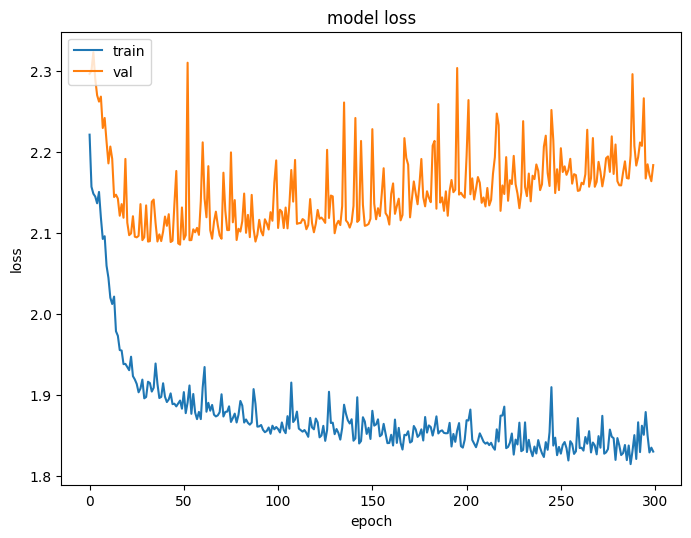

making predictions...
eveluating the model...
16/16 [==============================] - 0s 2ms/step - loss: 1.7901
plotting predictions...


<Figure size 432x288 with 0 Axes>

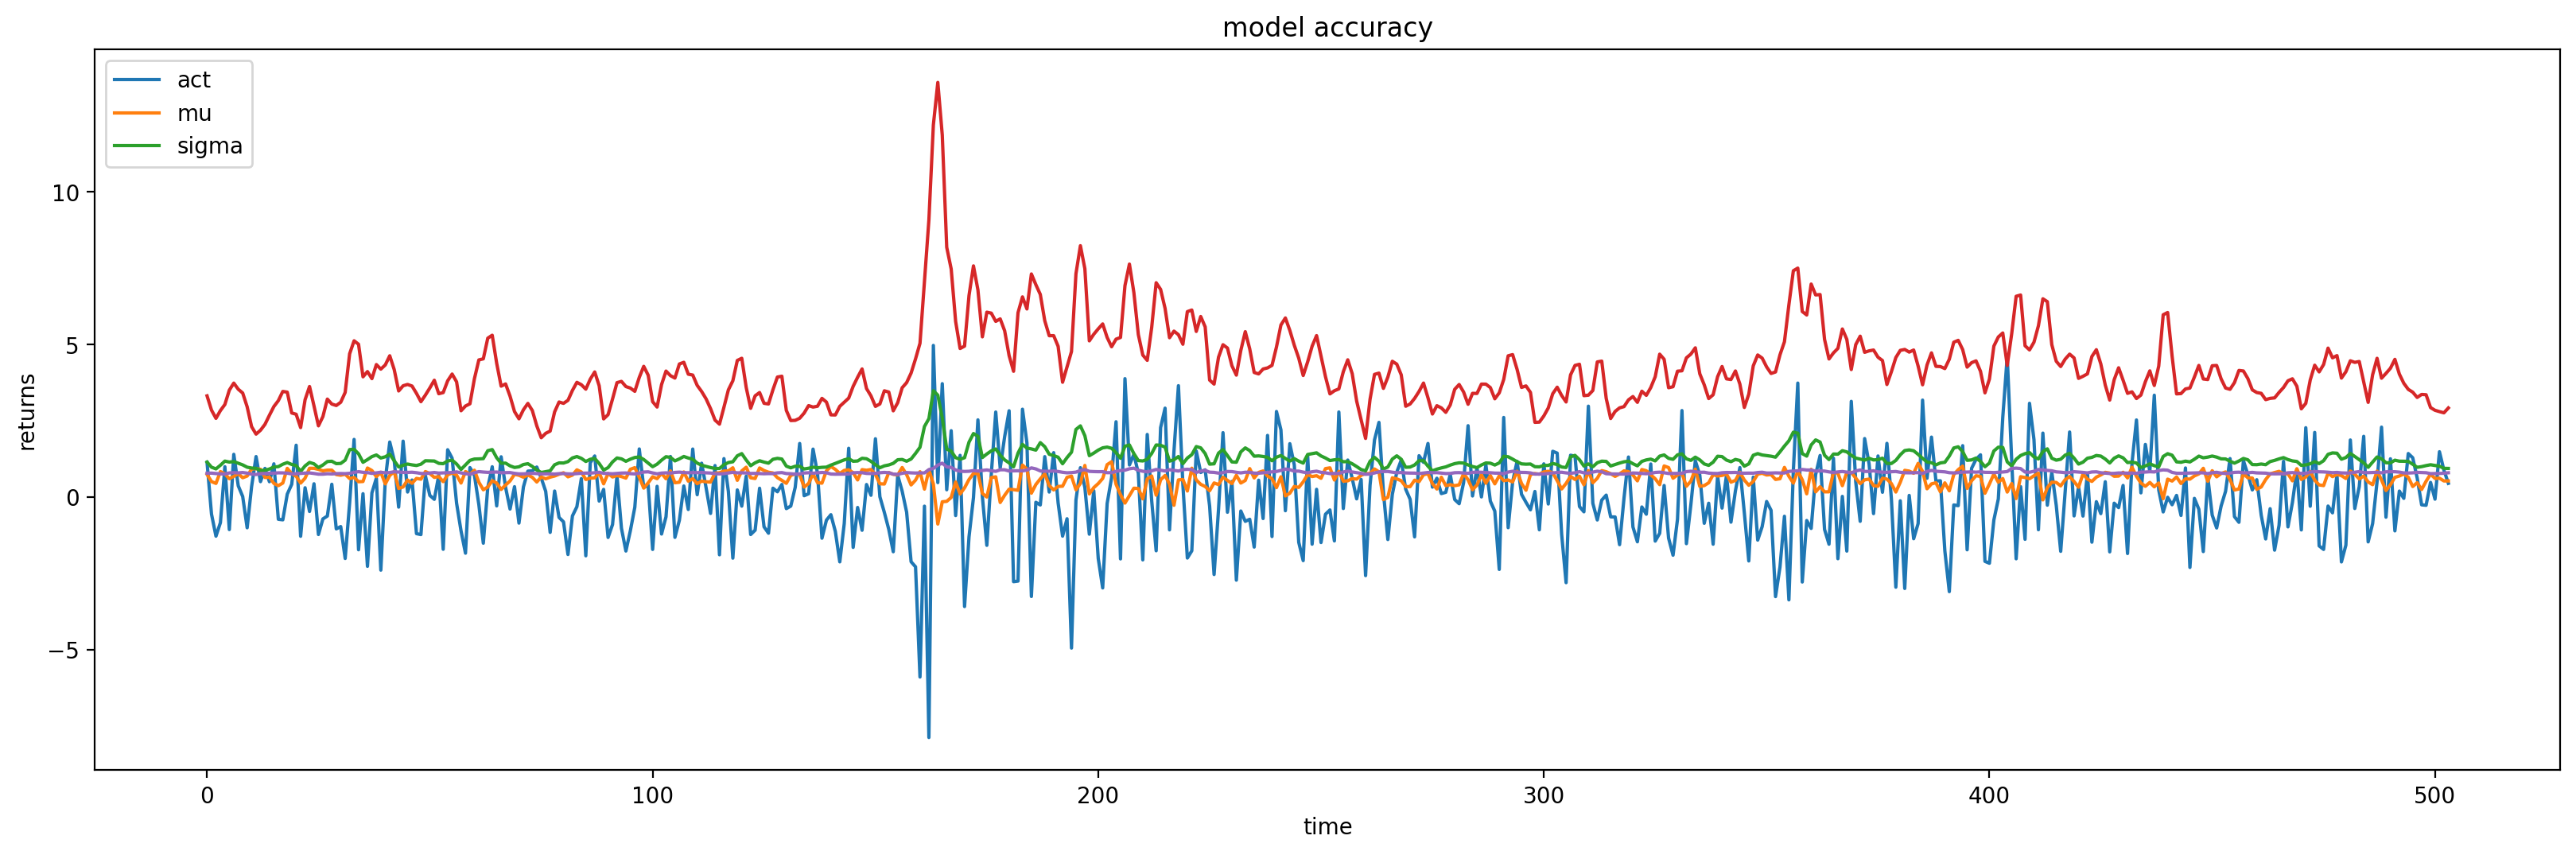

training the model...
Epoch 1/300

Epoch 1: val_loss improved from inf to 2.01100, saving model to best_model.h5
27/27 - 2s - loss: 2.3303 - val_loss: 2.0110 - 2s/epoch - 71ms/step
Epoch 2/300

Epoch 2: val_loss improved from 2.01100 to 1.98116, saving model to best_model.h5
27/27 - 0s - loss: 2.2681 - val_loss: 1.9812 - 197ms/epoch - 7ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.98116 to 1.98010, saving model to best_model.h5
27/27 - 0s - loss: 2.2533 - val_loss: 1.9801 - 177ms/epoch - 7ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 1.98010
27/27 - 0s - loss: 2.2370 - val_loss: 1.9808 - 126ms/epoch - 5ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.98010 to 1.97808, saving model to best_model.h5
27/27 - 0s - loss: 2.2245 - val_loss: 1.9781 - 173ms/epoch - 6ms/step
Epoch 6/300

Epoch 6: val_loss improved from 1.97808 to 1.96421, saving model to best_model.h5
27/27 - 0s - loss: 2.2130 - val_loss: 1.9642 - 176ms/epoch - 7ms/step
Epoch 7/300

Epoch 7: val_los

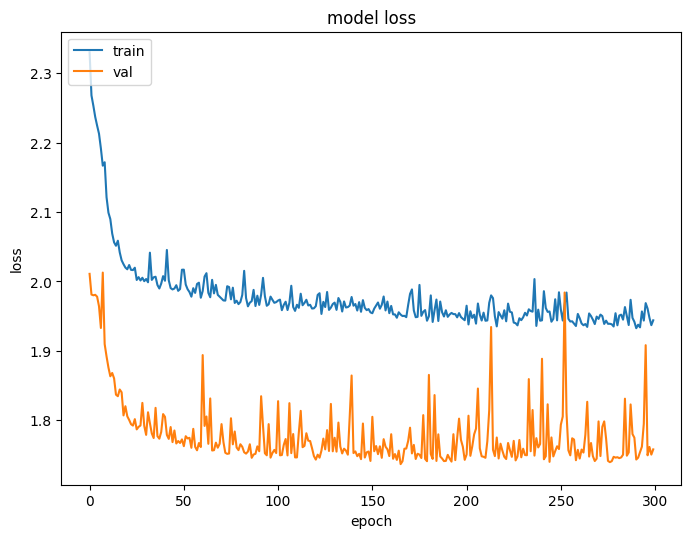

making predictions...
eveluating the model...
16/16 [==============================] - 0s 2ms/step - loss: 1.8014
plotting predictions...


<Figure size 432x288 with 0 Axes>

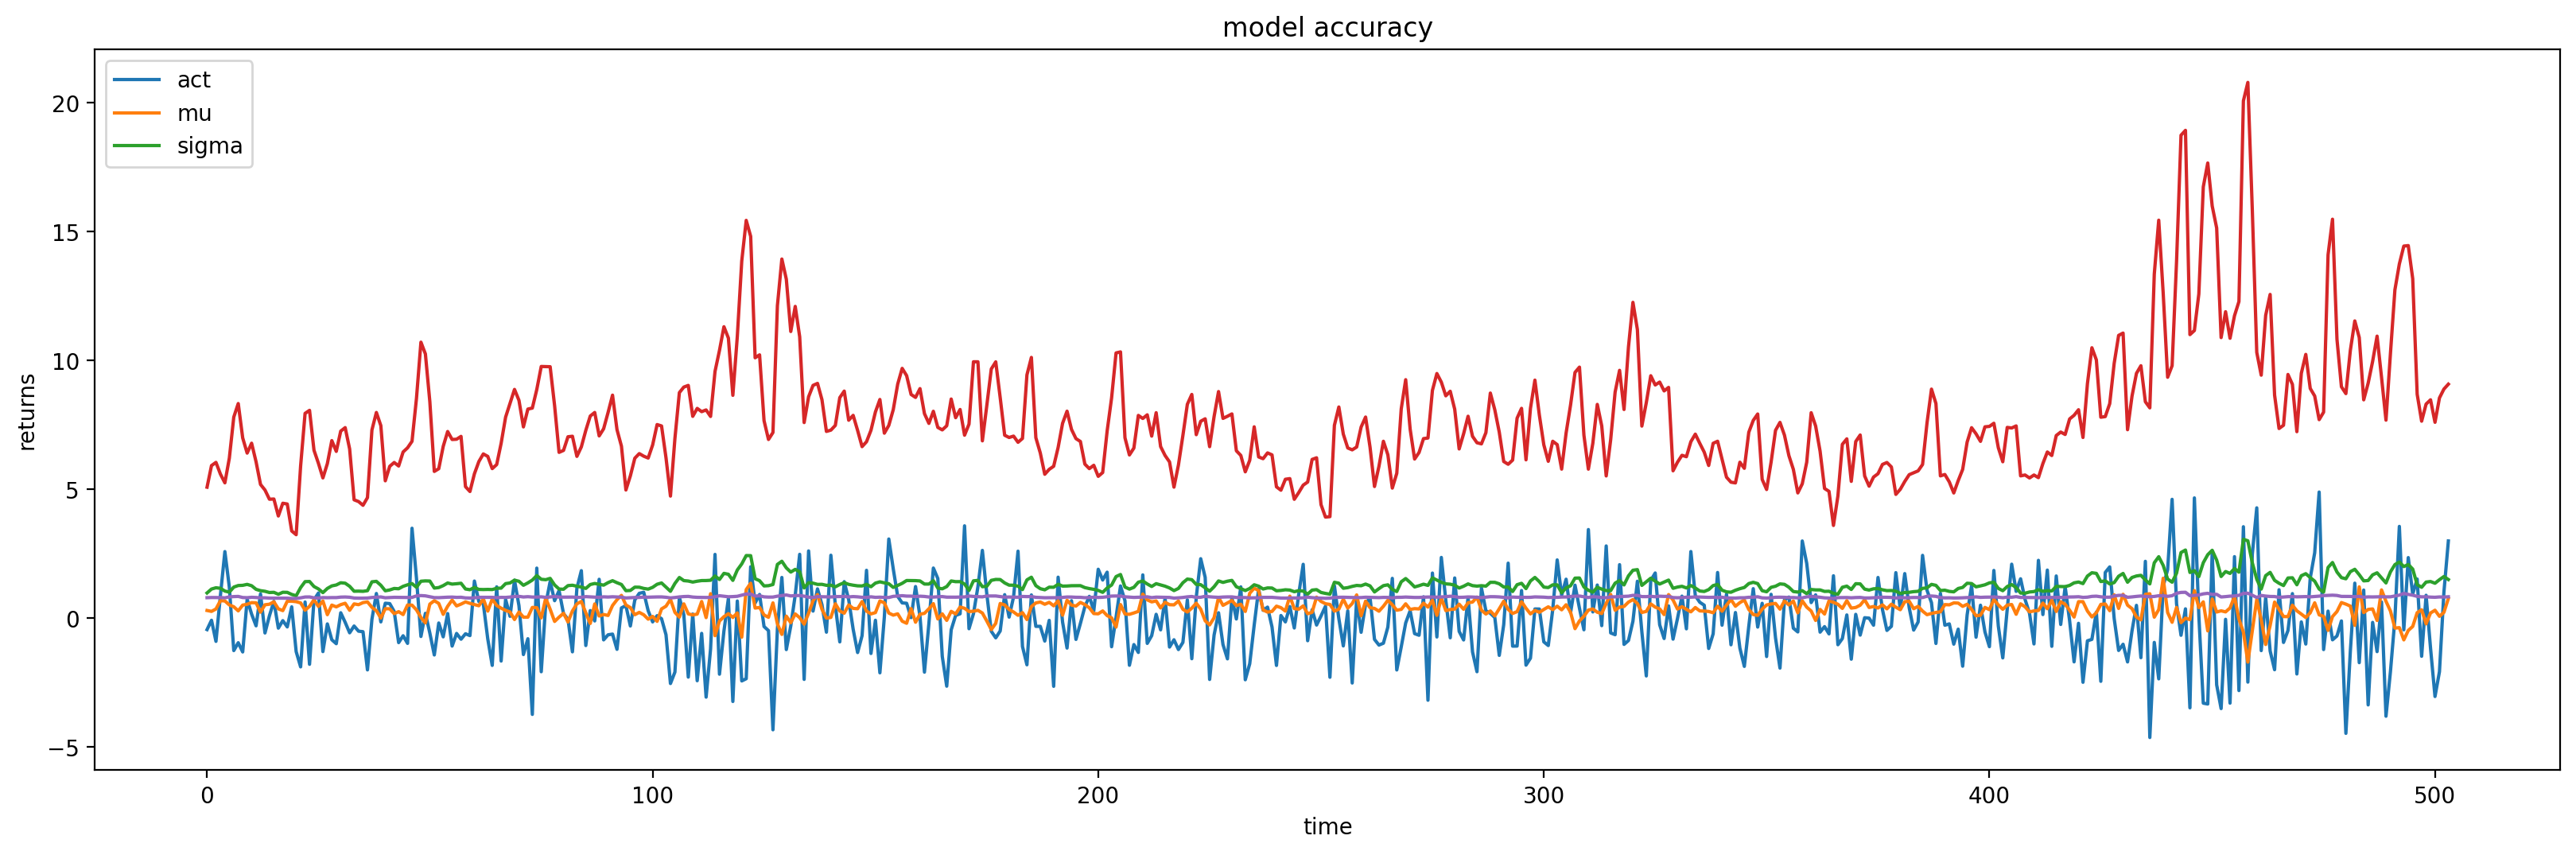

training the model...
Epoch 1/300

Epoch 1: val_loss improved from inf to 2.07652, saving model to best_model.h5
32/32 - 2s - loss: 2.2570 - val_loss: 2.0765 - 2s/epoch - 48ms/step
Epoch 2/300

Epoch 2: val_loss improved from 2.07652 to 2.02507, saving model to best_model.h5
32/32 - 0s - loss: 2.2028 - val_loss: 2.0251 - 168ms/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 2.02507
32/32 - 0s - loss: 2.2062 - val_loss: 2.1138 - 143ms/epoch - 4ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 2.02507
32/32 - 0s - loss: 2.1766 - val_loss: 2.0360 - 137ms/epoch - 4ms/step
Epoch 5/300

Epoch 5: val_loss improved from 2.02507 to 2.01091, saving model to best_model.h5
32/32 - 0s - loss: 2.1715 - val_loss: 2.0109 - 169ms/epoch - 5ms/step
Epoch 6/300

Epoch 6: val_loss improved from 2.01091 to 1.99587, saving model to best_model.h5
32/32 - 0s - loss: 2.1503 - val_loss: 1.9959 - 158ms/epoch - 5ms/step
Epoch 7/300

Epoch 7: val_loss improved from 1.99587 to 1.95751,

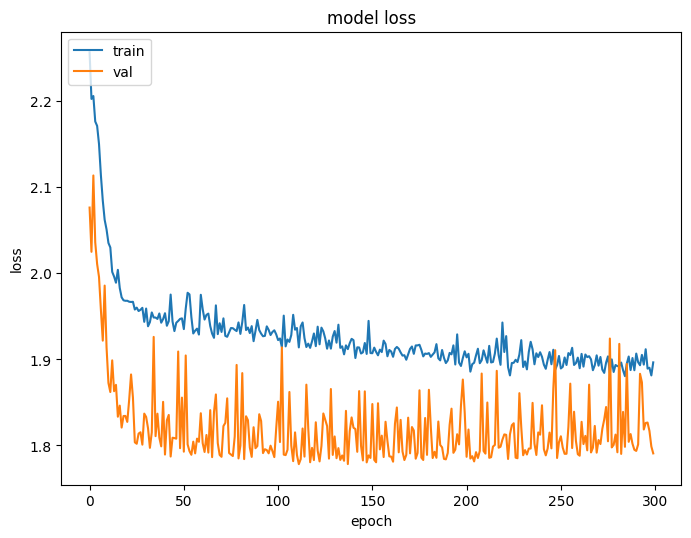

making predictions...
eveluating the model...
16/16 [==============================] - 0s 1ms/step - loss: 1.8722
plotting predictions...


<Figure size 432x288 with 0 Axes>

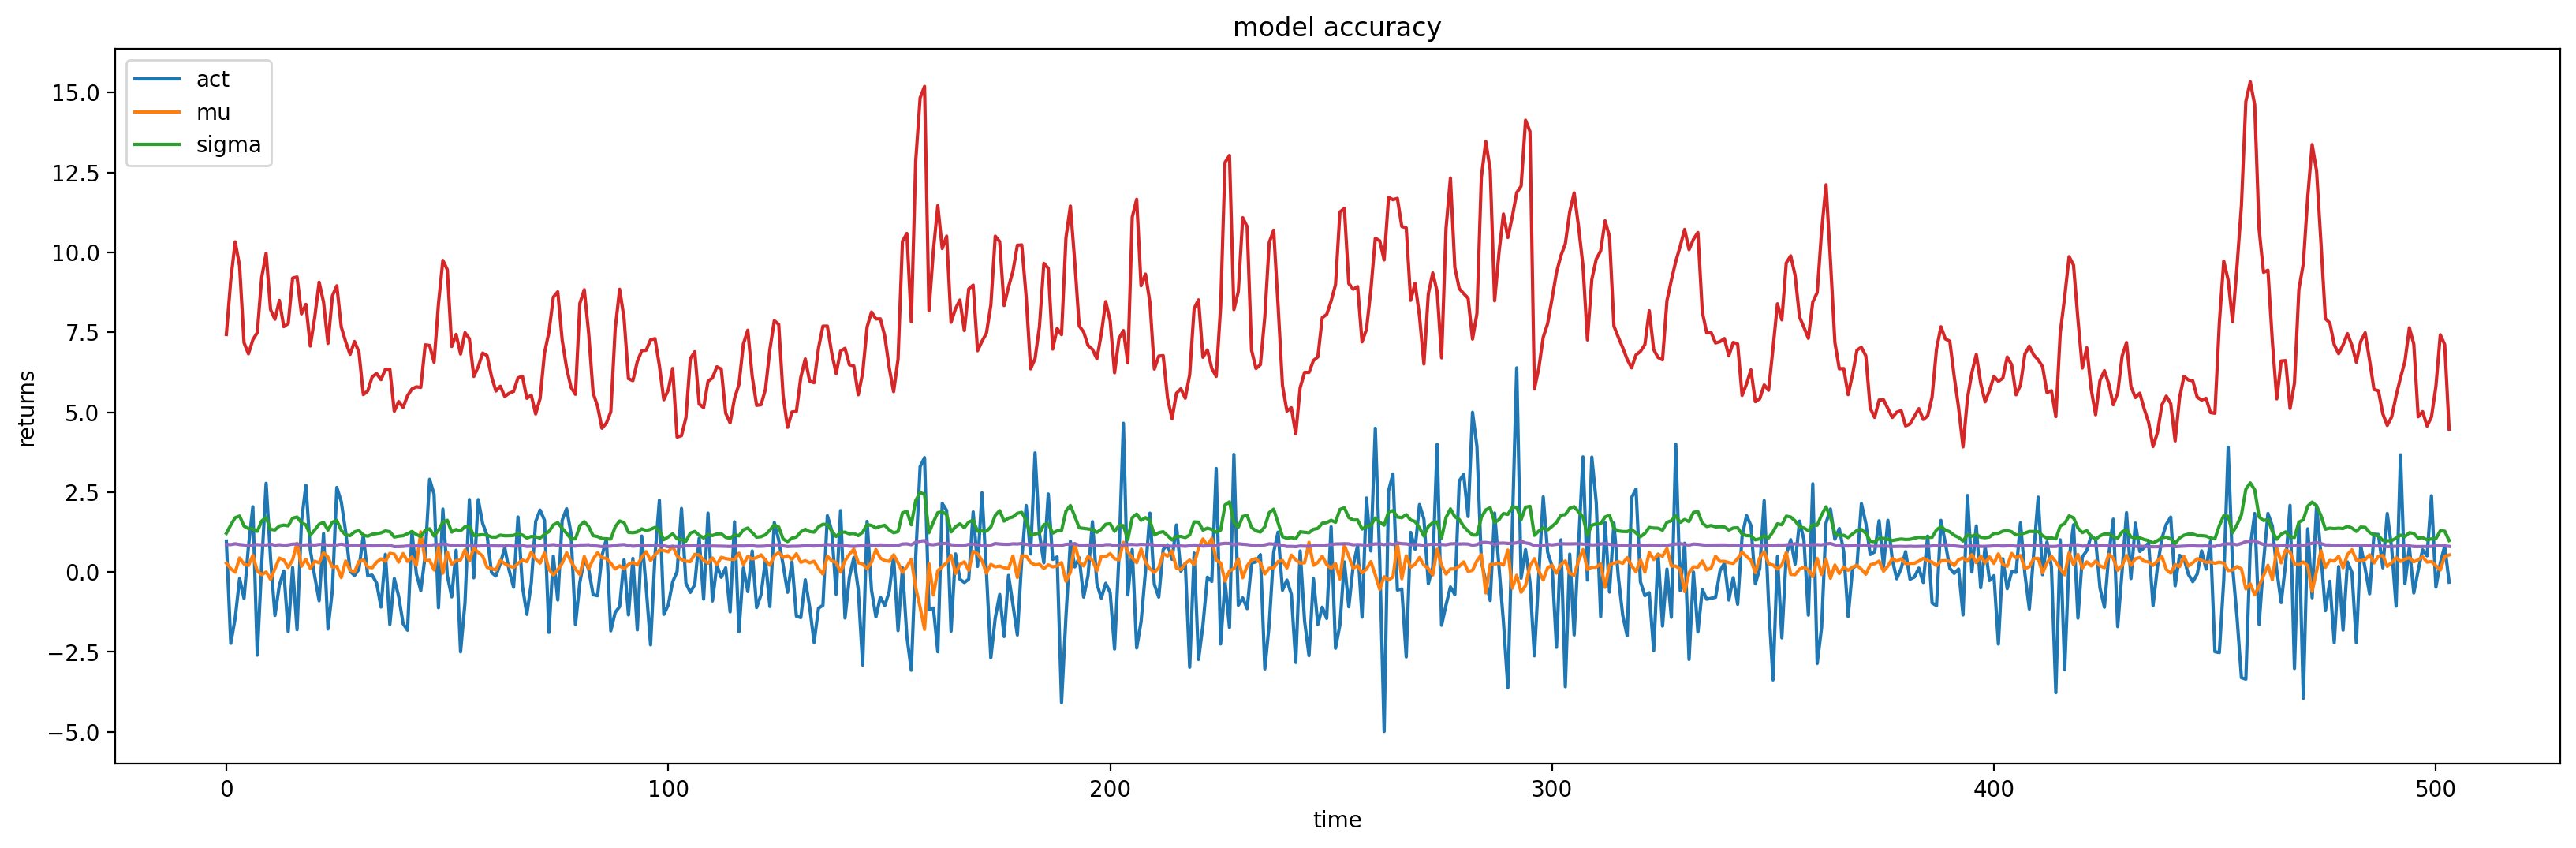

training the model...
Epoch 1/300

Epoch 1: val_loss improved from inf to 2.10050, saving model to best_model.h5
37/37 - 2s - loss: 2.2110 - val_loss: 2.1005 - 2s/epoch - 46ms/step
Epoch 2/300

Epoch 2: val_loss did not improve from 2.10050
37/37 - 0s - loss: 2.1704 - val_loss: 2.1035 - 178ms/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_loss improved from 2.10050 to 2.05940, saving model to best_model.h5
37/37 - 0s - loss: 2.1727 - val_loss: 2.0594 - 168ms/epoch - 5ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 2.05940
37/37 - 0s - loss: 2.1464 - val_loss: 2.0693 - 150ms/epoch - 4ms/step
Epoch 5/300

Epoch 5: val_loss improved from 2.05940 to 2.03975, saving model to best_model.h5
37/37 - 0s - loss: 2.1221 - val_loss: 2.0398 - 186ms/epoch - 5ms/step
Epoch 6/300

Epoch 6: val_loss improved from 2.03975 to 1.97985, saving model to best_model.h5
37/37 - 0s - loss: 2.0962 - val_loss: 1.9798 - 184ms/epoch - 5ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 1.97985
37/3

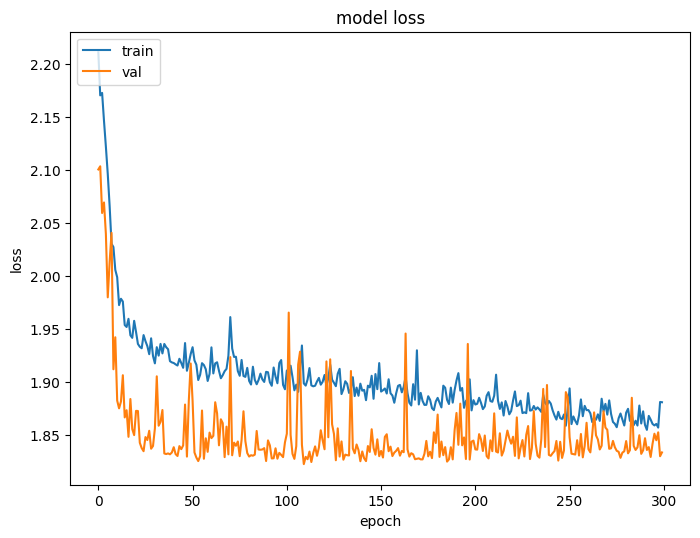

making predictions...
eveluating the model...
16/16 [==============================] - 0s 604us/step - loss: 1.6582
plotting predictions...


<Figure size 432x288 with 0 Axes>

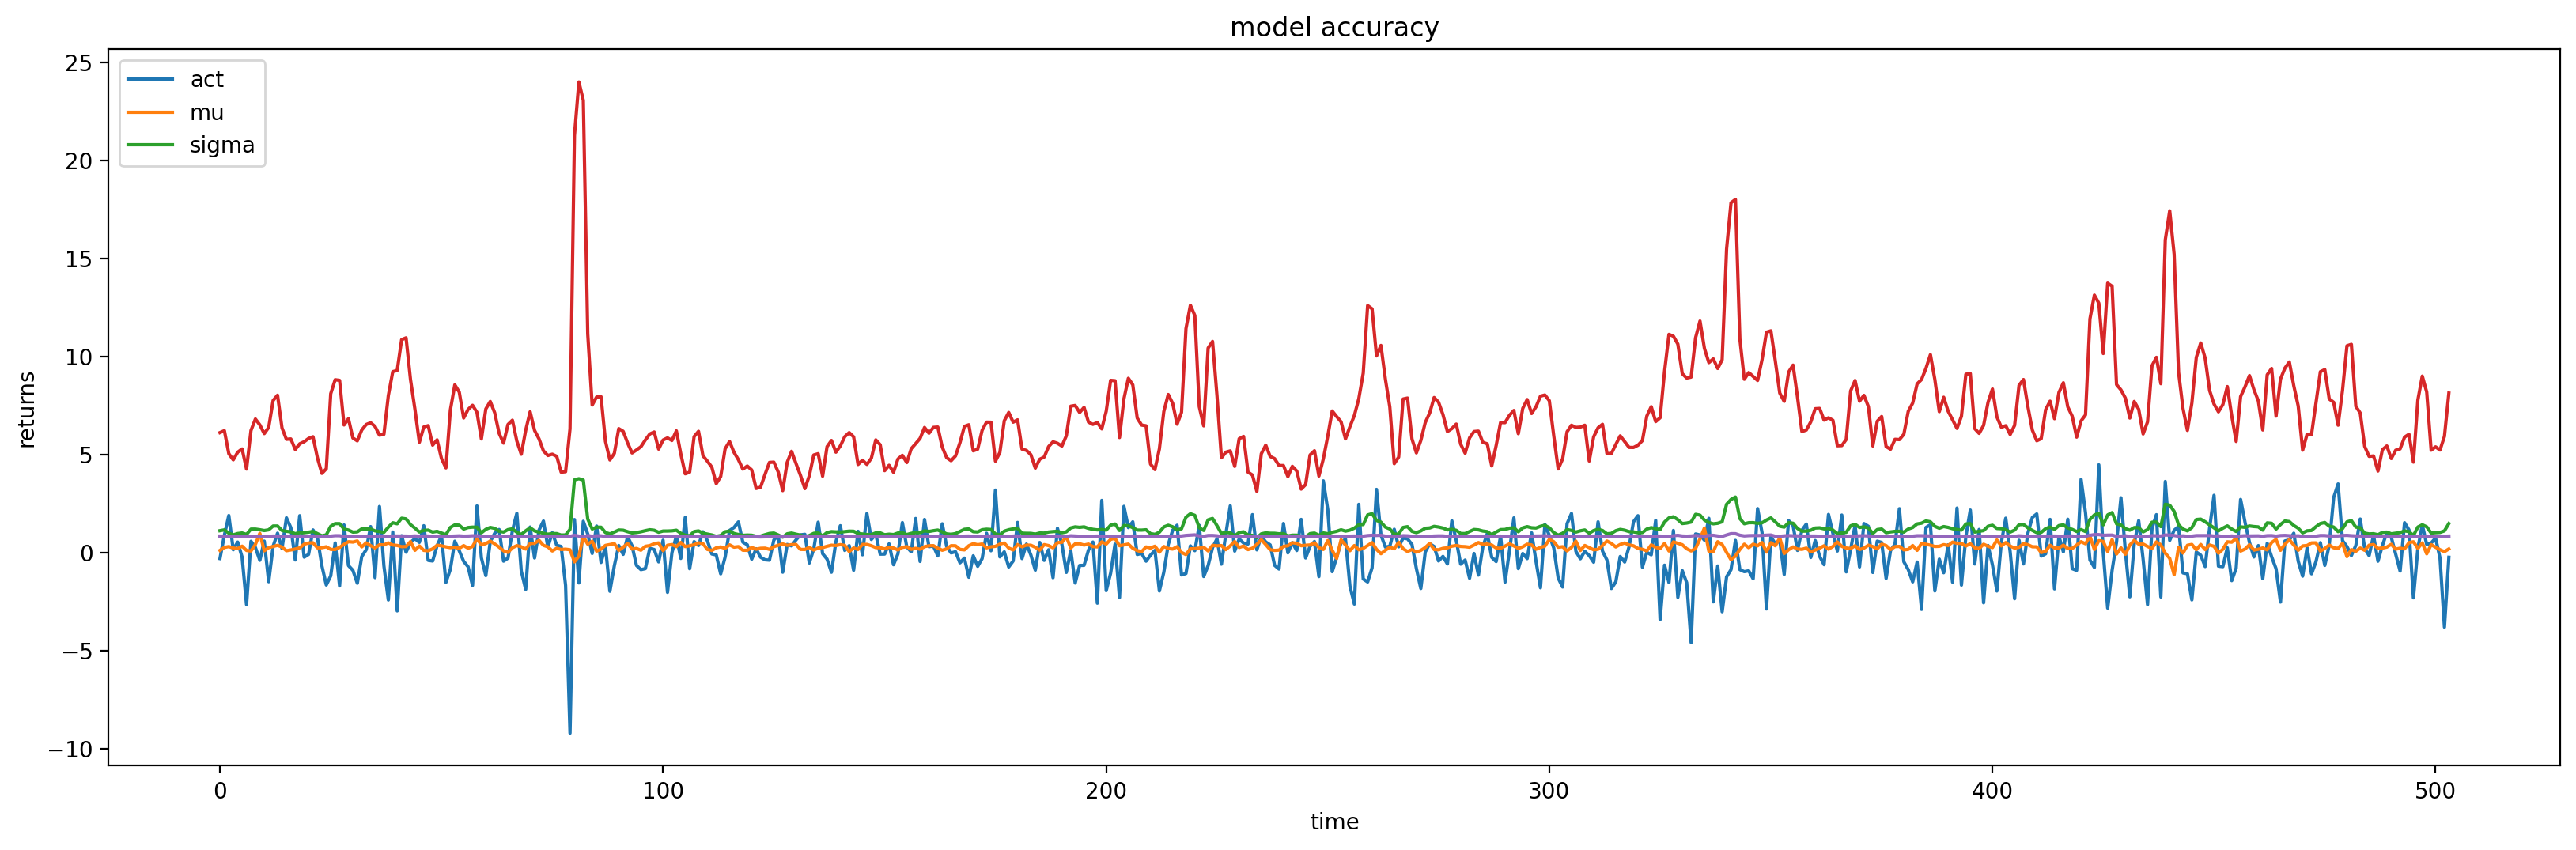

training the model...
Epoch 1/300

Epoch 1: val_loss improved from inf to 2.02281, saving model to best_model.h5
42/42 - 2s - loss: 2.1965 - val_loss: 2.0228 - 2s/epoch - 40ms/step
Epoch 2/300

Epoch 2: val_loss did not improve from 2.02281
42/42 - 0s - loss: 2.1535 - val_loss: 2.0356 - 164ms/epoch - 4ms/step
Epoch 3/300

Epoch 3: val_loss improved from 2.02281 to 2.02276, saving model to best_model.h5
42/42 - 0s - loss: 2.1400 - val_loss: 2.0228 - 185ms/epoch - 4ms/step
Epoch 4/300

Epoch 4: val_loss improved from 2.02276 to 1.99750, saving model to best_model.h5
42/42 - 0s - loss: 2.1133 - val_loss: 1.9975 - 191ms/epoch - 5ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.99750 to 1.94622, saving model to best_model.h5
42/42 - 0s - loss: 2.0785 - val_loss: 1.9462 - 203ms/epoch - 5ms/step
Epoch 6/300

Epoch 6: val_loss improved from 1.94622 to 1.90760, saving model to best_model.h5
42/42 - 0s - loss: 2.0471 - val_loss: 1.9076 - 208ms/epoch - 5ms/step
Epoch 7/300

Epoch 7: val_los

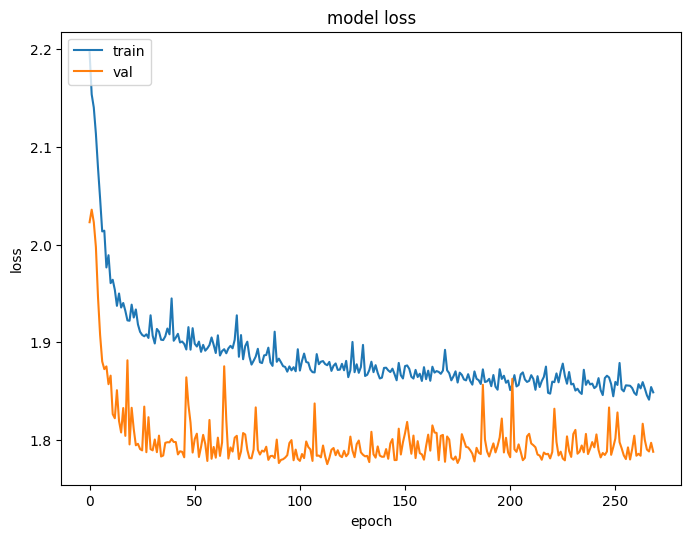

making predictions...
eveluating the model...
15/15 [==============================] - 0s 2ms/step - loss: 1.8036
plotting predictions...


<Figure size 432x288 with 0 Axes>

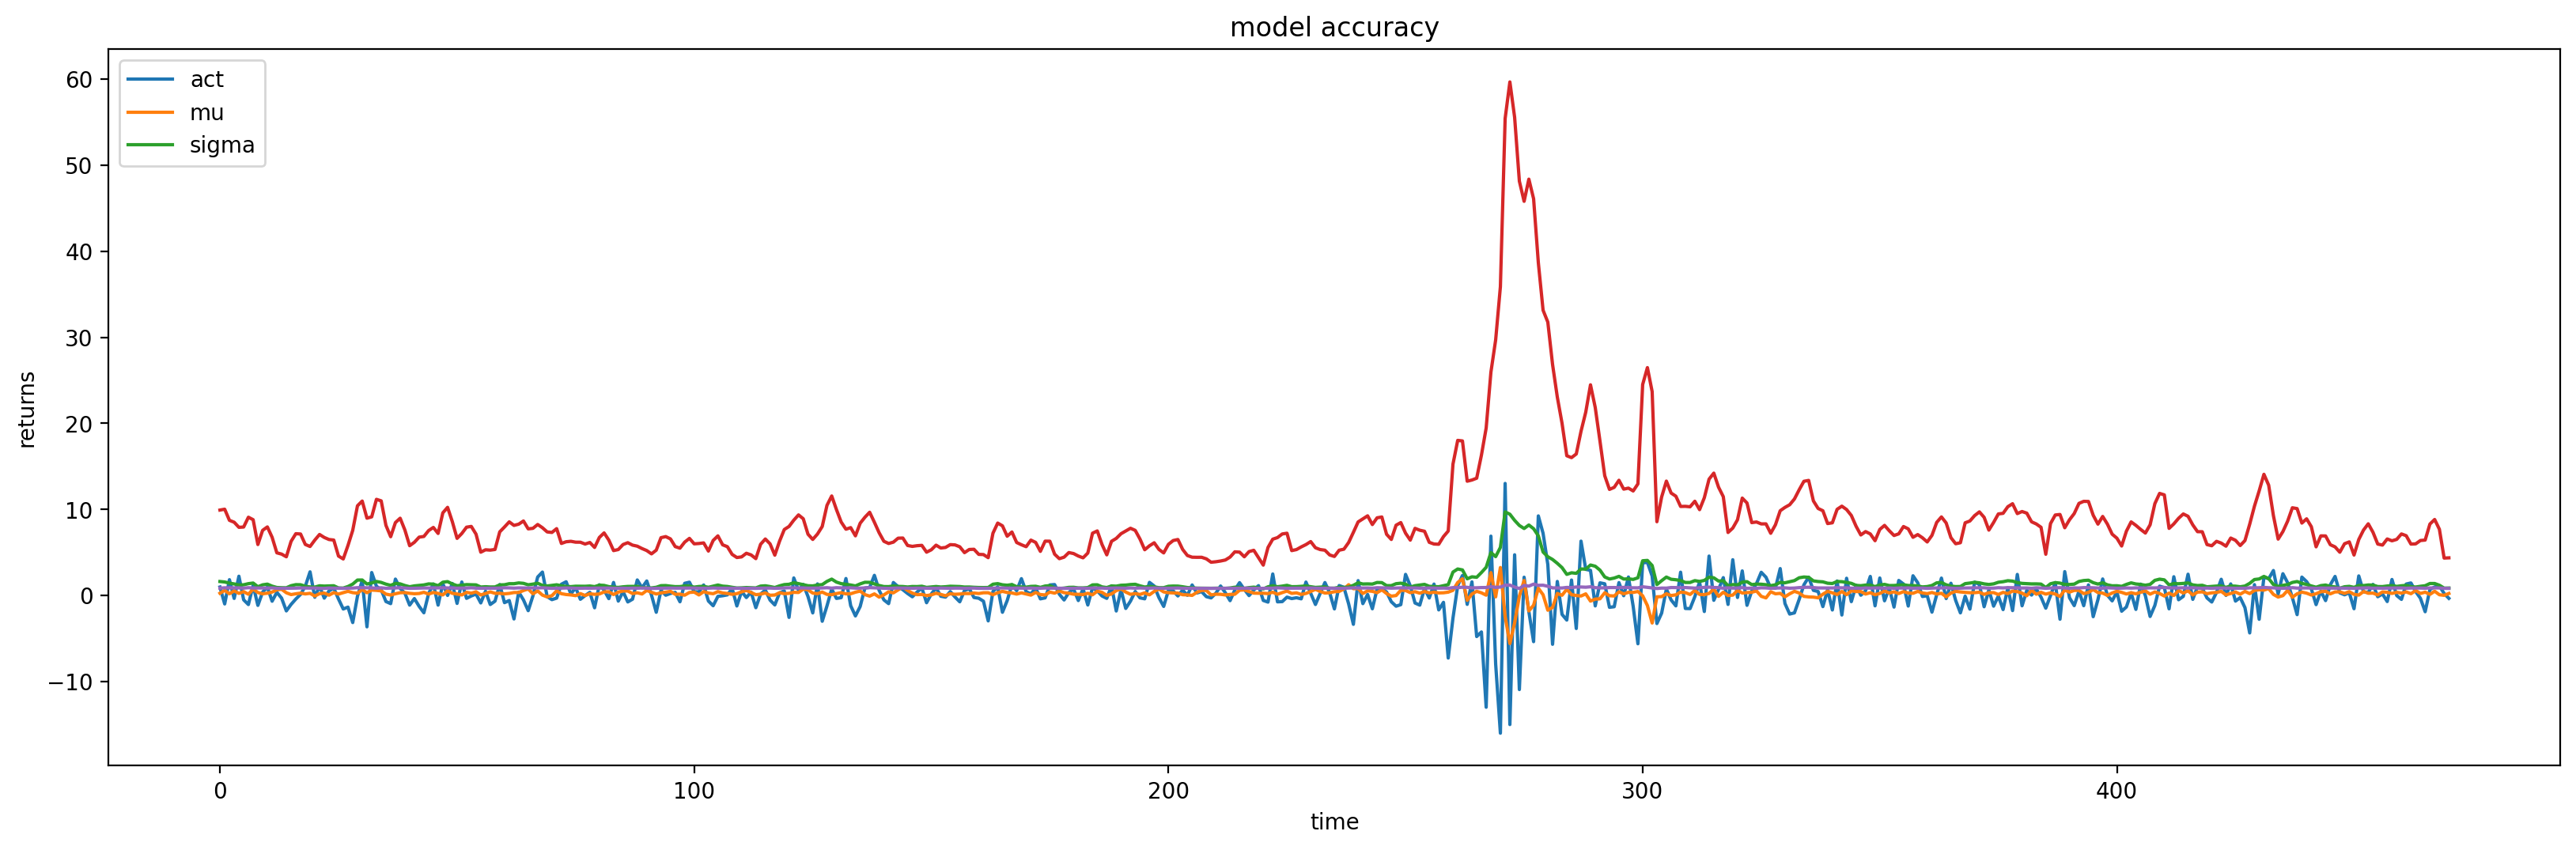

In [ ]:


#initialize random weights
initializer = initializers.HeUniform(seed=0)

#train test split/rolling window

data = dataset[-4495:] #last 3495 obs
train_size = 2008
window_size = 504 #test size
splits = []
yhat_total_mu = []
yhat_total_sigma = []
yhat_total_nu = []
yhat_total_xi = []


for i in range(train_size, len(data), window_size):
    #train = np.array(data[i-train_size:i])
    train = np.array(data[0:i])
    test = np.array(data[i-n_steps:i+window_size])
    splits.append(('TRAIN:', train, 'TEST:', test))
    X,y = split_sequences(train, n_steps)
    #print(X[0],y[0])
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    #print(X)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights = True) # ten ostatni argument robi to samo co mc
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=2)
    
    
    # define model
    #negloglik = lambda y, rv_y: -rv_y.log_prob(y)

    model  = Sequential([ 
        
        #Conv1D(filters=256, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=(n_steps, n_features), padding='causal'),
        Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), padding='causal'),

        Dropout(0.02),
        
        MaxPooling1D(pool_size=3),
        Flatten(),
        
        # LSTM(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.002), return_sequences=True, input_shape=(n_steps, n_features) ),
        # Dropout(0.02),
        # LSTM(64,activation=tf.keras.layers.LeakyReLU(alpha=0.1),  kernel_regularizer=regularizers.l2(0.002), return_sequences=True),
        # Dropout(0.02),
        # LSTM(32, kernel_regularizer=regularizers.l2(0.002),  activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        # Dropout(0.02),
        
        Dense(4),
      
    ])


    opt = tf.keras.optimizers.Adam(learning_rate = 0.003, clipnorm=1)
    model.compile(optimizer = opt, loss=loss_skew_st)
    
    
    # fit model
    print("training the model...")
    history = model.fit(X, y, batch_size = 64, validation_split = 0.3333, epochs=300, verbose=2, callbacks = [mc])
    
    #plot loss
    print("plotting loss...")
    from matplotlib.pyplot import figure
    %matplotlib inline

    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig("file_name.png")
    plt.show()
    
    #load mc model
    saved_model = load_model('best_model.h5', compile=False)
    saved_model.compile(optimizer=opt, loss = loss_skew_st)
    
    #split test set
    Xtest, ytest = split_sequences(test, n_steps)
    Xtest = Xtest.reshape((Xtest.shape[0], Xtest.shape[1], n_features))
    
    #make predictions on test set
    print("making predictions...")
    yhat = saved_model(Xtest) #full output
    #assert isinstance(yhat, tfd.Distribution)

    yhat_mu = yhat[:,0]
    yhat_sigma = tf.math.softplus(0.01 * yhat[:,1])
    yhat_nu = tf.math.softplus(0.01 * yhat[:,2])
    yhat_xi = tf.math.softplus(0.01 * yhat[:,3])

    # yhat_mu = yhat.mean()
    # yhat_sigma = yhat.stddev()
    
    # #evalueate test set
    print("eveluating the model...")
    ev = saved_model.evaluate(Xtest, ytest,verbose=1)
    
    #plot predictions
    print("plotting predictions...")
    
    figs = plt.figure()
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(ytest)
    plt.plot(yhat_mu) #mu
    plt.plot(yhat_sigma)
    plt.plot(yhat_nu)
    plt.plot(yhat_xi)
    #plt.plot(np.exp(yhat_sigma)) # exp(log sigma) bo prognozujemy log żeby nie było ujemnych wartosci
    #plt.plot(garch_forecasts[['Mu']][-568:].reset_index(drop=True))
    #plt.plot(Xtest)
    plt.title('model accuracy')
    plt.ylabel('returns')
    plt.xlabel('time')
    plt.legend(['act', 'mu', 'sigma'], loc='upper left')
    plt.show()
    
    yhat_r_mu = np.reshape(yhat_mu, (len(yhat_mu)))
    yhat_total_mu.extend(yhat_mu.numpy().tolist())
    
    yhat_r_sigma = np.reshape(yhat_sigma, (len(yhat_sigma)))
    yhat_total_sigma.extend(yhat_sigma.numpy().tolist())

    yhat_r_nu = np.reshape(yhat_nu, (len(yhat_nu)))
    yhat_total_nu.extend(yhat_nu.numpy().tolist())

    yhat_r_xi = np.reshape(yhat_xi, (len(yhat_xi)))
    yhat_total_xi.extend(yhat_xi.numpy().tolist())

    yhat_total = pd.DataFrame(yhat_total_mu)
    yhat_total .rename(columns={"0": "mu"})
    yhat_total[['sigma']] = pd.DataFrame(yhat_total_sigma)
    yhat_total[['nu']] = pd.DataFrame(yhat_total_nu)
    
    yhat_total[['xi']] = pd.DataFrame(yhat_total_xi)
    yhat_total['Realized_Ret'] = garch_forecasts[['Realized Ret']].tail(len(yhat_total_sigma)).reset_index(drop=True)


In [21]:
yhat_total

,0,sigma,nu,xi,Realized_Ret
0,0.691019,1.103666,2.940840,0.780816,1.141353
1,0.473265,0.937514,2.630227,0.792724,-0.556108
2,0.391567,0.916974,2.470805,0.778807,-1.277830
3,0.894556,1.018433,2.534067,0.757280,-0.834099
4,0.759480,1.152717,2.591745,0.746988,0.997631
...,...,...,...,...,...
2482,0.228033,1.393864,6.006886,0.820453,0.699998
2483,0.633778,1.390290,6.676343,0.826921,0.998715
2484,0.279367,1.184898,6.062467,0.821883,1.111561
2485,0.202800,0.872159,3.747900,0.798092,0.239380


In [6]:
feather.write_feather(yhat_total, '../EXPORTS/prob_bvp_lstm_sstd.feather')